In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../src')

In [4]:
import torch
import scipy.sparse as sp
import glob
import warnings
import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd

In [5]:
import spaceoracle
from spaceoracle.models.estimators import device

In [6]:
adata_train = sc.read_h5ad('./.cache/adata_train.h5ad')
adata_train

AnnData object with n_obs × n_vars = 11567 × 5013
    obs: 'cluster', 'rctd_cluster', 'rctd_celltypes'
    uns: 'log1p'
    obsm: 'X_spatial', 'rctd_results', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [31]:
so = spaceoracle.SpaceOracle(
    adata=adata_train,
    annot='rctd_cluster', 
    max_epochs=30, 
    learning_rate=1e-3, 
    spatial_dim=64,
    batch_size=512,
    threshold_lambda=3e3,
    save_dir='/tmp/models2'
)

In [32]:
so.queue

OracleQueue with 4971 remaining genes

In [33]:
so.save_dir

'/tmp/models2'

In [34]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator
from spaceoracle.models.pixel_attention import CellularNicheNetwork

In [35]:
adata_train.shape

(11567, 5013)

In [36]:
from tqdm import tqdm
import polars as pl
from pqdm.threads import pqdm

In [37]:
%%time

scans = {}
for gene in tqdm(so.queue.completed_genes, total=len(so.queue.completed_genes)):
    scans[gene] = pl.scan_csv(f'{so.save_dir}/{gene}_betadata.csv')

beta_cols = lambda x: [i for i in x if 'beta_' in i and '$' not in i]

100%|██████████| 31/31 [00:00<00:00, 116092.34it/s]

CPU times: user 1.71 ms, sys: 119 ms, total: 121 ms
Wall time: 120 ms


In [ ]:
'Il2', 'Ebf1', 'Pax5', 'Bach2', 'Tcf3'

In [38]:
def do_one_gene(gene):
    scanned = scans[gene]
    beta_df = scanned.select(beta_cols(scanned.columns)).collect()
    beta_df = beta_df.with_columns(
        [pl.lit(0.0).alias('beta_'+col) for col in list(set(so.adata.var_names) - set(scanned.columns))+[gene]])
    
    b = beta_df.select(['beta_'+i for i in so.adata.var_names]).to_torch().unsqueeze(2).float()
    if ko.shape[0] == b.shape[0]:
        return torch.bmm(ko, b).squeeze().squeeze().numpy()
    else:
        return torch.zeros(11567, ).numpy()

In [39]:
from glob import glob

In [42]:
len(glob(f'{so.save_dir}/*_betadata.csv'))

31

In [43]:
%%time

for g in [i.split('/')[-1].split('_')[0] for i in glob(f'{so.save_dir}/*_betadata.csv')]:
   _ = do_one_gene(g).sum()

CPU times: user 40.1 s, sys: 9.09 s, total: 49.2 s
Wall time: 13.5 s


In [21]:
do_one_gene('Irak1').sum()

13.471229

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
# Scale the data using MinMaxScaler
scaled_data = MinMaxScaler().fit_transform(adata_train.to_df(layer='imputed_count'))

pd.DataFrame(
    scaled_data, 
    index=adata_train.obs_names, 
    columns=adata_train.var_names).to_csv('/tmp/gex.csv', index=True)

# You can now use scaled_df for further analysis

NameError: name 'MinMaxScaler' is not defined

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
mtx = MinMaxScaler().fit_transform(adata_train.to_df(layer='imputed_count'))
ko = mtx.copy()
ko[:, list(adata_train.var_names).index('Pax5')] = 0
ko = ko - mtx
ko = torch.from_numpy(ko).unsqueeze(1).float()
ko.shape

torch.Size([11567, 1, 5013])

In [332]:
y_pred = do_one_gene('Cd74')
y_obs = MinMaxScaler().fit_transform(
    adata_train.to_df(layer='imputed_count')['Cd74'].values.reshape(-1, 1)).reshape(-1)
(y_pred+y_obs).mean(), y_obs.mean()

(0.29999547841562263, 0.33392365294605103)

In [333]:
rdf = pd.DataFrame(
    np.column_stack([so.adata.obsm['spatial'], y_obs, y_pred, 
                     (y_pred+y_obs), y_pred/(y_obs+1)]), 
    columns=['x', 'y', 'y_obs', 'y_delta', 'y_new', 'm']).join(
    so.adata.obs.reset_index()
    ).set_index('index')

In [334]:
rdf[['y_delta', 'rctd_celltypes']].groupby('rctd_celltypes').mean()

,y_delta
rctd_celltypes,
B-cell,-0.044799
Cd8 T-cell,-0.014232
NK,-0.020605
Resting T-cell,-0.009748
Tfh,-0.019750
Th2,-0.012170
Treg,-0.012928


In [343]:
rdf.sort_values('x').query('rctd_celltypes=="Th2"')

,x,y,y_obs,y_delta,y_new,m,rctd_cluster,rctd_celltypes
index,,,,,,,,
GATCCCCCAAACAC,-5235.1,3764.8,0.113096,-0.024830,0.088267,-0.022307,2,Th2
CGACTAAGTGCCTT,-4608.4,3843.0,0.087340,-0.020838,0.066502,-0.019164,2,Th2
ATTGATGGGTTGTG,-4292.7,2924.5,0.321450,-0.061552,0.259897,-0.046579,2,Th2
TCACTGTTACTAAT,-4277.0,2850.4,0.121802,-0.015467,0.106335,-0.013787,2,Th2
TTCCGCTGGTAAGC,-4260.3,3000.0,0.124178,-0.024103,0.100074,-0.021441,2,Th2
...,...,...,...,...,...,...,...,...
GCCTAGCGTGGCCT,-1294.0,3562.7,0.220640,-0.041321,0.179319,-0.033852,2,Th2
TCGCAGCTGGGTAA,-1284.9,1927.1,0.211924,-0.033036,0.178888,-0.027259,2,Th2
CTCAAGGACGTAAC,-1250.0,3586.4,0.283736,-0.041176,0.242560,-0.032075,2,Th2


In [351]:
rdf.loc[['AGTCTCGTGTTTAC', 'TGCTAATGAAGTCC', 'TCACTGTTACTAAT', 'TTCCGCTGGTAAGC']]

,x,y,y_obs,y_delta,y_new,m,rctd_cluster,rctd_celltypes
index,,,,,,,,
AGTCTCGTGTTTAC,-2813.0,3221.0,0.004415,-0.005495,-0.001080,-0.005471,2,Th2
TGCTAATGAAGTCC,-2448.8,1941.8,0.004470,-0.001122,0.003348,-0.001117,2,Th2
TCACTGTTACTAAT,-4277.0,2850.4,0.121802,-0.015467,0.106335,-0.013787,2,Th2
TTCCGCTGGTAAGC,-4260.3,3000.0,0.124178,-0.024103,0.100074,-0.021441,2,Th2


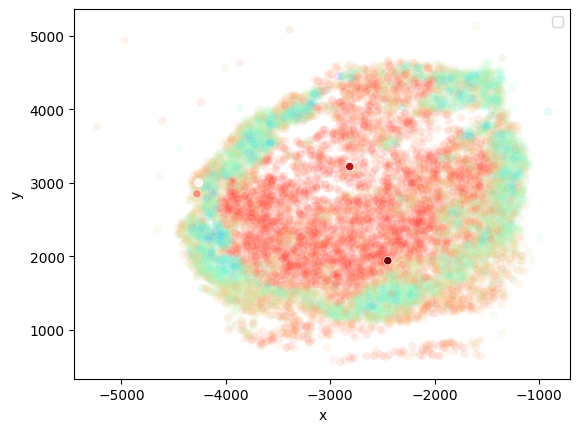

In [350]:
sns.scatterplot(data=rdf, x='x', y='y', hue='y_delta', palette='rainbow', alpha=0.1)
sns.scatterplot(
    data=rdf.lock[['AGTCTCGTGTTTAC', 'TGCTAATGAAGTCC', 'TCACTGTTACTAAT', 'TTCCGCTGGTAAGC']], 
    x='x', y='y', hue='y_delta', palette='Reds', alpha=1)
plt.legend('')

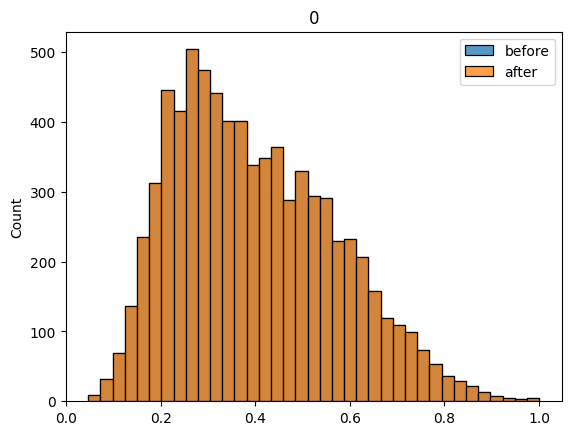

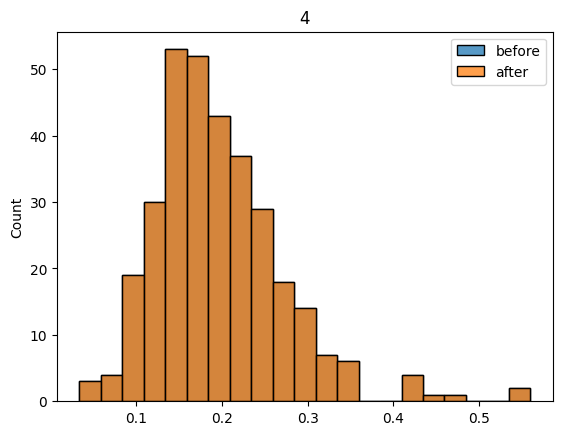

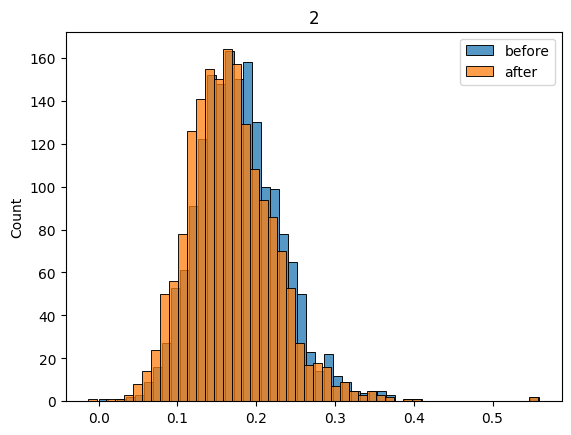

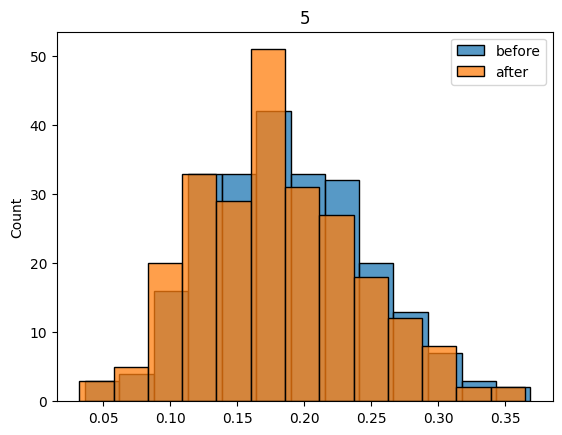

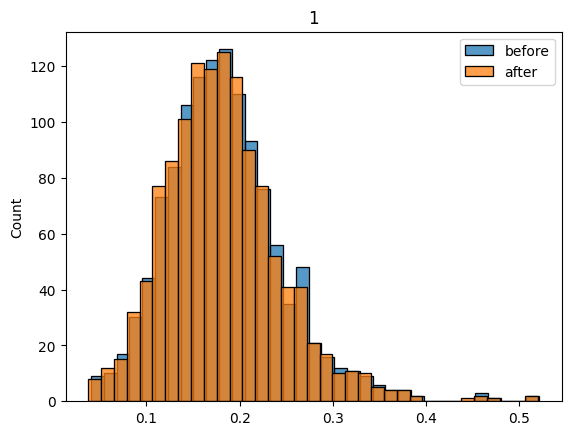

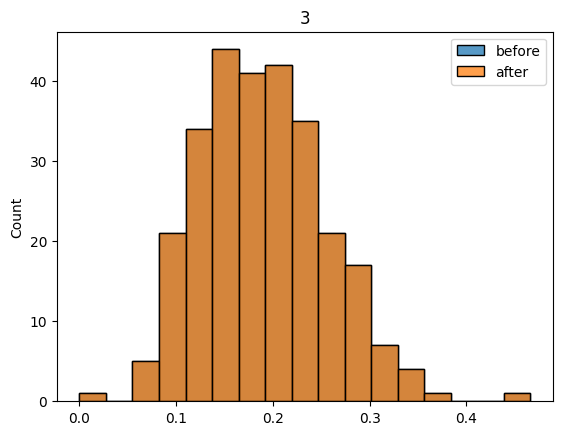

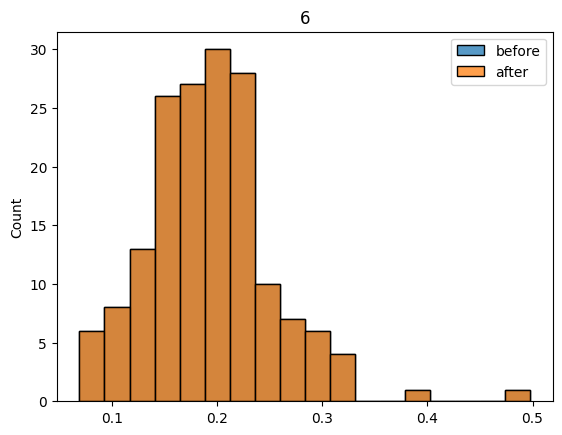

In [277]:
for cluster in so.adata.obs.rctd_cluster.unique():
    sns.histplot(y_obs[so.adata.obs.rctd_cluster.values==cluster], label='before')
    sns.histplot((y_obs+y_pred)[so.adata.obs.rctd_cluster.values==cluster], label='after')
    plt.title(cluster)
    plt.legend()
    plt.show()

In [45]:
so.queue.completed_genes.__len__()

31

In [46]:
%%time

results = pqdm(so.queue.completed_genes, do_one_gene, n_jobs=16, tqdm_class=tqdm)

QUEUEING TASKS | : 100%|██████████| 31/31 [00:00<00:00, 530.26it/s]
PROCESSING TASKS | : 100%|██████████| 31/31 [00:08<00:00,  3.79it/s]
COLLECTING RESULTS | : 100%|██████████| 31/31 [00:00<00:00, 123361.88it/s]

CPU times: user 28.3 s, sys: 18.6 s, total: 46.9 s
Wall time: 8.25 s


In [47]:
len(results)

31

In [49]:
np.array([results]).shape

(1, 31, 11567)

In [218]:
mtx_s = MinMaxScaler().fit_transform(
    adata_train.to_df(layer='imputed_count')[so.queue.completed_genes])
perturbed_mtx = mtx_s + \
        np.array([results]).reshape(11567, -1)
perturbed_mtx.shape

(11567, 3118)

In [ ]:
perturbed_mtx

In [230]:
pdf = pd.DataFrame(perturbed_mtx, columns = so.queue.completed_genes, index=so.adata.obs_names)
odf = pd.DataFrame(mtx_s, columns = so.queue.completed_genes, index=so.adata.obs_names)

In [233]:
# pdf.to_csv('/ix/djishnu/shared/djishnu_kor11/ko_Il2ra_lymph.csv')

In [238]:
(odf-pdf)[['Pax5']].join(so.adata.obs['rctd_celltypes']).groupby('rctd_celltypes').mean()

,Pax5
rctd_celltypes,
B-cell,0.000475
Cd8 T-cell,-0.000719
NK,-0.000828
Resting T-cell,0.001931
Tfh,0.000702
Th2,-0.000292
Treg,0.000760


In [247]:
(odf-pdf).mean().abs().sort_values(ascending=False)[:10]

Tnfsf13b         0.000858
1810013L24Rik    0.000854
Gpr160           0.000802
Rspry1           0.000787
Lyl1             0.000778
Xrn2             0.000743
Map2k5           0.000726
Scyl1            0.000718
Sfxn4            0.000711
Csad             0.000706
dtype: float64

<AxesSubplot: xlabel='Cd74', ylabel='Density'>

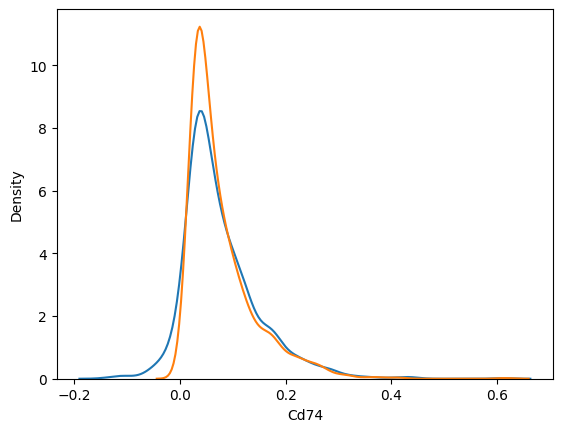

In [158]:
sns.kdeplot(pdf['Cd74'][so.adata.obs.rctd_cluster.values==1])
sns.kdeplot(odf['Cd74'][so.adata.obs.rctd_cluster.values==1])

,0,1,2,3,4,5,6,7,8,9,...,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117
0,0.360496,0.343977,0.376852,0.469339,0.439539,0.397375,0.261263,0.094710,0.376741,0.122417,...,0.338936,0.375166,0.409603,0.393623,0.432700,0.453144,0.358332,0.427338,0.498345,0.388938
1,0.406682,0.519332,0.000000,0.279946,0.168317,0.288125,0.056449,0.000000,0.356175,0.000000,...,0.453717,0.437290,0.227371,0.393028,0.541362,0.548398,0.418473,0.543650,0.407189,0.286855
2,0.498626,0.474282,0.155415,0.447542,0.347634,0.377409,0.509701,0.094710,0.699583,0.274646,...,0.468164,0.421459,0.510817,0.284205,0.282568,0.220854,0.380876,0.268923,0.317529,0.336620
3,0.602292,0.415089,0.000000,0.471794,0.471414,0.377189,0.571889,0.212083,0.349593,0.306003,...,0.346977,0.333489,0.214511,0.297337,0.453923,0.546961,0.349790,0.352129,0.331314,0.452486
4,0.402498,0.811026,0.000000,0.452688,0.362725,0.365830,0.353010,0.094710,0.364740,0.306003,...,0.295309,0.199289,0.451294,0.384211,0.423756,0.204196,0.255782,0.121096,0.453728,0.399343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11562,0.508080,0.319637,0.146077,0.602411,0.402434,0.417445,0.450148,0.094710,0.371977,0.306003,...,0.409421,0.365622,0.465846,0.308383,0.381117,0.504139,0.221580,0.271023,0.366400,0.501635
11563,0.434247,0.417501,0.146755,0.462404,0.346496,0.348408,0.094967,0.000000,0.138083,0.000000,...,0.409365,0.412907,0.401664,0.645838,0.368486,0.383619,0.222730,0.504084,0.448739,0.286394
11564,0.416667,0.652213,0.146755,0.453017,0.231849,0.231457,0.088756,0.000000,0.118552,0.000000,...,0.533182,0.443276,0.426114,0.602825,0.251397,0.511203,0.418473,0.420158,0.447008,0.388960
11565,0.534494,0.424388,0.155415,0.304555,0.485545,0.428911,0.276740,0.094710,0.298155,0.122417,...,0.403771,0.361575,0.403749,0.454133,0.387476,0.502936,0.498969,0.370767,0.434673,0.252232


In [149]:
MinMaxScaler().fit_transform(
    .values)

ValueError: Expected 2D array, got 1D array instead:
array=[0.43869694 0.19366086 0.91757034 ... 0.18124846 0.52641002 0.77782165].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [60]:
perturbed_mtx.sum()

0.0

In [108]:
import polars as pl
from sklearn.preprocessing import MinMaxScaler

In [55]:
dfp = pd.DataFrame(
    perturbed_mtx, 
    columns=so.queue.completed_genes, 
    index=adata_train.obs.index
)

In [59]:
dfp.mean().sort_values()

Cuedc1      0.0
Rrp36       0.0
Gm14029     0.0
Mphosph6    0.0
Ccdc17      0.0
           ... 
Trappc2     0.0
Zfp740      0.0
Dpp3        0.0
Mylk        0.0
Pam16       0.0
Length: 3118, dtype: float64

In [199]:


so.adata.layers['imputed_count_x'] = MinMaxScaler().fit_transform(so.adata.to_df(layer='imputed_count')).copy()


In [1]:
a = so.adata.to_df(layer='imputed_count_x')[
    [i.replace('beta_', '') for i in pf.columns if 'beta_' in i and '$' not in i]]

b = pf.select([i for i in pf.columns if 'beta_' in i and '$' not in i])

b_df = b.collect().to_pandas().T
x = np.dot(a.values, b_df.values)


NameError: name 'so' is not defined

array([[ 0.28007812, -0.04051343,  0.15958447, ..., -0.03462685,
         0.31443103,  0.21435754],
       [ 0.46306534,  0.00732259,  0.34380948, ...,  0.0652749 ,
         0.48570801,  0.39414799],
       [-0.07848071, -0.12410852, -0.18379771, ..., -0.22430586,
        -0.06750554, -0.13180281],
       ...,
       [ 0.45067318,  0.04259218,  0.33686556, ...,  0.07121389,
         0.48584401,  0.38571585],
       [ 0.28318993, -0.02398201,  0.17628194, ..., -0.02812186,
         0.30458408,  0.21605886],
       [ 0.0151861 , -0.17410771, -0.1007747 , ..., -0.15588143,
         0.03175832, -0.05388208]])

In [200]:
pl.LazyFrame(so.adata.to_df(layer='imputed_count_x'))

In [159]:
%%time
predict_target = 'Cd74'
df = pd.read_csv(
    f'{so.save_dir}/{predict_target}_betadata.csv', 
    index_col=0, engine='pyarrow')

CPU times: user 585 ms, sys: 830 ms, total: 1.42 s
Wall time: 1.03 s


In [160]:
df

,beta0,beta_Atf3,beta_Bcl11a,beta_Bcl11b,beta_Cebpb,beta_Ctcf,beta_Ebf1,beta_Ebf3,beta_Egr1,beta_Egr2,...,beta_Sdc3,beta_Sdc4,beta_Tnfrsf13c,beta_Tnfrsf1a,beta_Tnfrsf9,beta_Tyro3,rctd_cluster,rctd_celltypes,x,y
,,,,,,,,,,,,,,,,,,,,,
AAAAAACGGTAGAT,3.464415e-01,0.0,0.154783,-0.203103,0.022913,-0.025036,0.157274,0.000000,-0.104113,-0.019142,...,0.006689,0.012263,0.006604,0.0,-0.017173,0.0,0,B-cell,-4252.0,2626.2
AAAAAATCCGGCGA,8.919667e-06,0.0,0.154262,-0.009042,0.035950,0.000000,0.233174,0.014037,-0.000278,0.000000,...,-0.003049,0.007139,0.001158,0.0,0.000000,0.0,4,Tfh,-2952.4,1975.3
AAAAACCGTCAGAC,3.489022e-01,0.0,0.154434,-0.202912,0.022806,-0.024939,0.156985,0.000000,-0.103930,-0.019058,...,0.008017,0.019456,0.026976,0.0,-0.005566,0.0,0,B-cell,-2480.0,1516.6
AAAAACGCTCCGAC,3.462958e-01,0.0,0.154773,-0.203099,0.022909,-0.025033,0.157264,0.000000,-0.104107,-0.019140,...,0.001441,0.011801,0.017611,0.0,-0.008514,0.0,0,B-cell,-2764.1,1255.7
AAAAAGCACGTGTT,3.494486e-01,0.0,0.154377,-0.202878,0.022789,-0.024924,0.156937,0.000000,-0.103901,-0.019044,...,0.002797,0.012916,0.015879,0.0,-0.011062,0.0,0,B-cell,-3925.9,1618.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTCGCGGCTA,1.160928e-05,0.0,0.153827,-0.009198,0.035771,0.000000,0.233052,0.013946,-0.000309,0.000000,...,-0.001636,0.051669,0.010252,0.0,0.000000,0.0,4,Tfh,-3754.4,1504.7
TTTTTTGGGCTGGT,3.886279e-08,0.0,0.146614,-0.000216,0.000613,0.000000,0.243857,0.000000,0.000000,0.000000,...,0.007463,0.010457,0.002877,0.0,0.000000,0.0,2,Th2,-3547.4,2483.1
TTTTTTGTACCCAC,4.171620e-08,0.0,0.146591,-0.000222,0.000623,0.000000,0.243810,0.000000,0.000000,0.000000,...,0.007452,0.006297,0.004575,0.0,0.000000,0.0,2,Th2,-1666.5,2309.1


In [161]:
est = SpatialCellularProgramsEstimator(so.adata, predict_target)
_ = est.init_data()

In [162]:
beta_out = so._get_betas(predict_target)

In [163]:
so.adata.var_names[beta_out.modulator_gene_indices]

Index(['Atf3', 'Bcl11a', 'Bcl11b', 'Cebpb', 'Ctcf', 'Ebf1', 'Ebf3', 'Egr1',
       'Egr2', 'Foxj3',
       ...
       'Pard3', 'Pirb', 'Plxna3', 'Sdc2', 'Sdc3', 'Sdc4', 'Tnfrsf13c',
       'Tnfrsf1a', 'Tnfrsf9', 'Tyro3'],
      dtype='object', length=139)

In [14]:
beta_out.betas[:, 1:].mean(0).shape

(120,)

In [15]:
gene_gene_matrix = np.zeros((len(so.adata.var_names), len(so.adata.var_names)))
gene_gene_matrix.shape

(5013, 5013)

In [17]:
beta_out.betas[0, 1:].shape

(120,)

In [285]:
gene_gene_matrix[
    beta_out.modulator_gene_indices, 
    list(so.adata.var_names).index('Cd74')
] = beta_out.betas[0, 1:]

In [274]:
est.modulators_genes.__len__()

120

In [260]:
est.modulators.__len__()

112

In [261]:
df[[f'beta_{i}' for i in est.modulators_genes]].mean(0).abs().sort_values(ascending=False)[:20]

beta_Pax5       0.236295
beta_Bcl11a     0.154696
beta_Egr1       0.122718
beta_Il2rb      0.104896
beta_Angptl2    0.089244
beta_Angptl4    0.058342
beta_Ncl        0.055699
beta_C3         0.051384
beta_Osm        0.047970
beta_Lif        0.044795
beta_Rxra       0.044783
beta_Il15       0.044017
beta_Ccl2       0.038232
beta_Hdac2      0.037546
beta_Taf1       0.037172
beta_Il4        0.036890
beta_Ccl8       0.032282
beta_Gzma       0.031168
beta_Ccl5       0.029764
beta_Nr3c1      0.028388
dtype: float64

In [262]:
df['beta_Il2rb'].mean()

0.10489642629055788

In [265]:
so.adata.layers['imputed_count_x'] = MinMaxScaler().fit_transform(
    so.adata.to_df(layer='imputed_count')).copy()

y_new = (so.adata.to_df(layer='imputed_count_x')[predict_target]+(
    -1*so.adata.to_df(layer='imputed_count_x')['Bcl11a'] * df['beta_Bcl11a']))

y_o = so.adata.to_df(layer='imputed_count_x')[predict_target]

so.adata.obs.rctd_cluster[np.where(y_new!=y_o)[0]].value_counts()

rctd_cluster
0    7531
2    1784
1    1246
4     323
5     241
6     167
3       0
Name: count, dtype: int64

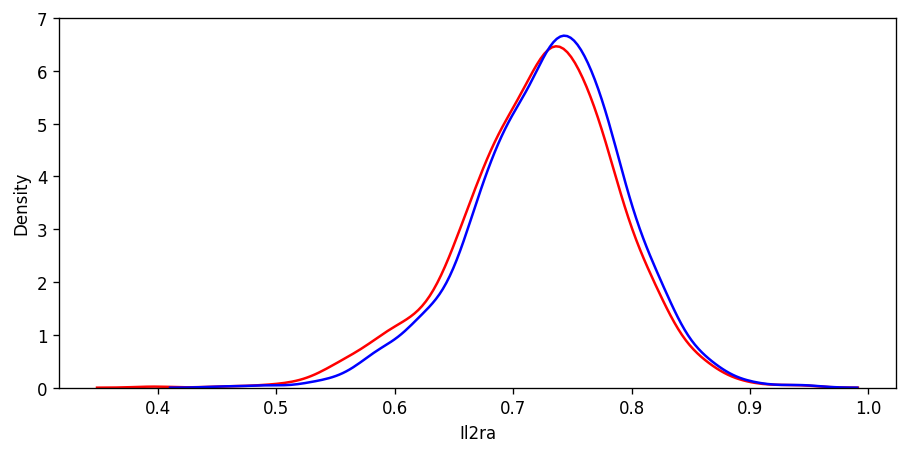

In [266]:
sns.kdeplot(y_o[so.adata.obs.rctd_cluster==1], color='red')
sns.kdeplot(y_new[so.adata.obs.rctd_cluster==1], color='blue')
plt.show()

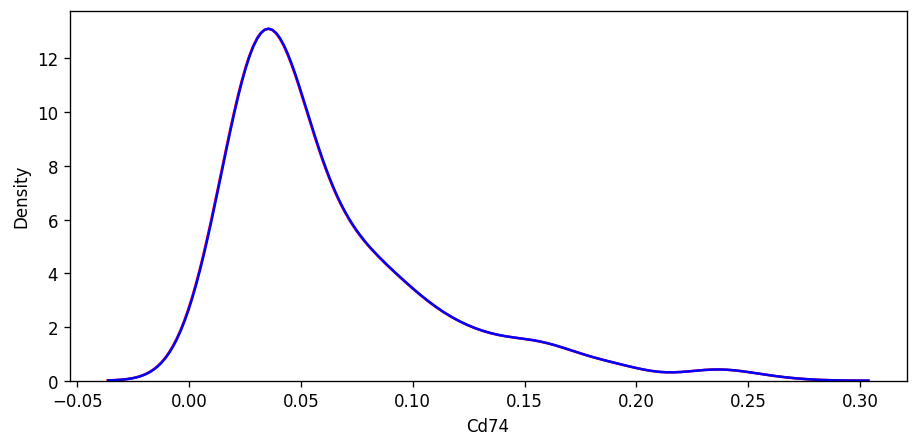

In [217]:
sns.kdeplot(y_o[so.adata.obs.rctd_cluster==3], color='red')
sns.kdeplot(y_new[so.adata.obs.rctd_cluster==3], color='blue')
plt.show()

In [13]:
betas = torch.from_numpy(
    df[['beta0']+['beta_'+i for i in est.modulators]].values).float()

inputs_x = torch.from_numpy(
    est.train_df.drop(
        columns=est.target_gene).values).float()

In [88]:
df

,beta0,beta_Atf3,beta_Bcl11a,beta_Bcl11b,beta_Cebpb,beta_Ctcf,beta_Ebf1,beta_Ebf3,beta_Egr1,beta_Egr2,...,beta_Sdc3,beta_Sdc4,beta_Tnfrsf13c,beta_Tnfrsf1a,beta_Tnfrsf9,beta_Tyro3,rctd_cluster,rctd_celltypes,x,y
AAAAAACGGTAGAT,3.464415e-01,0.0,0.154783,-0.203103,0.022913,-0.025036,0.157274,0.000000,-0.104113,-0.019142,...,0.006689,0.012263,0.006604,0.0,-0.017173,0.0,0,B-cell,-4252.0,2626.2
AAAAAATCCGGCGA,8.919667e-06,0.0,0.154262,-0.009042,0.035950,0.000000,0.233174,0.014037,-0.000278,0.000000,...,-0.003049,0.007139,0.001158,0.0,0.000000,0.0,4,Tfh,-2952.4,1975.3
AAAAACCGTCAGAC,3.489022e-01,0.0,0.154434,-0.202912,0.022806,-0.024939,0.156985,0.000000,-0.103930,-0.019058,...,0.008017,0.019456,0.026976,0.0,-0.005566,0.0,0,B-cell,-2480.0,1516.6
AAAAACGCTCCGAC,3.462958e-01,0.0,0.154773,-0.203099,0.022909,-0.025033,0.157264,0.000000,-0.104107,-0.019140,...,0.001441,0.011801,0.017611,0.0,-0.008514,0.0,0,B-cell,-2764.1,1255.7
AAAAAGCACGTGTT,3.494486e-01,0.0,0.154377,-0.202878,0.022789,-0.024924,0.156937,0.000000,-0.103901,-0.019044,...,0.002797,0.012916,0.015879,0.0,-0.011062,0.0,0,B-cell,-3925.9,1618.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTCGCGGCTA,1.160928e-05,0.0,0.153827,-0.009198,0.035771,0.000000,0.233052,0.013946,-0.000309,0.000000,...,-0.001636,0.051669,0.010252,0.0,0.000000,0.0,4,Tfh,-3754.4,1504.7
TTTTTTGGGCTGGT,3.886279e-08,0.0,0.146614,-0.000216,0.000613,0.000000,0.243857,0.000000,0.000000,0.000000,...,0.007463,0.010457,0.002877,0.0,0.000000,0.0,2,Th2,-3547.4,2483.1
TTTTTTGTACCCAC,4.171620e-08,0.0,0.146591,-0.000222,0.000623,0.000000,0.243810,0.000000,0.000000,0.000000,...,0.007452,0.006297,0.004575,0.0,0.000000,0.0,2,Th2,-1666.5,2309.1
TTTTTTGTACGATT,3.454244e-01,0.0,0.154889,-0.203164,0.022945,-0.025066,0.157364,0.000000,-0.104168,-0.019169,...,0.006964,0.008090,0.009949,0.0,-0.014287,0.0,0,B-cell,-2052.1,2937.7


In [14]:
y_pred = CellularNicheNetwork.predict_y(inputs_x, betas)

In [84]:
# plt.scatter(x=df[predict_target].values, y=y_pred, c=df.rctd_cluster, cmap='tab10')

In [16]:
so.adata.shape

(11567, 5013)

In [17]:
so.adata.n_obs

11567

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
import pickle

with open('/ix1/ylee/kor11/SpaceOracle_extras/beta_dict.pkl', 'rb') as handle:
    so.beta_dict = pickle.load(handle)

In [74]:
perturbed_matrix = so.perturb(
    so.adata.to_df(layer='imputed_count').values,
    target='Pax5', n_propagation=1)

Running simulation 1/1: 100%|██████████| 11567/11567 [08:53<00:00, 21.70it/s]


In [46]:
# import pickle

# with open('/ix1/ylee/kor11/SpaceOracle_extras/beta_dict.pkl', 'wb') as handle:
#     pickle.dump(so.beta_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [190]:
co_matrix = so.perturb_via_celloracle(
    so.adata.to_df(layer='imputed_count'),
     target='Pax5', n_propagation=1)

AAAAAACGGTAGAT     True
AAAAAATCCGGCGA    False
AAAAACCGTCAGAC     True
AAAAACGCTCCGAC     True
AAAAAGCACGTGTT     True
                  ...  
TTTTTTCGCGGCTA    False
TTTTTTGGGCTGGT    False
TTTTTTGTACCCAC    False
TTTTTTGTACGATT     True
TTTTTTTTGCTTTA     True
Name: rctd_cluster, Length: 11567, dtype: bool

<AxesSubplot: xlabel='Cd74', ylabel='Density'>

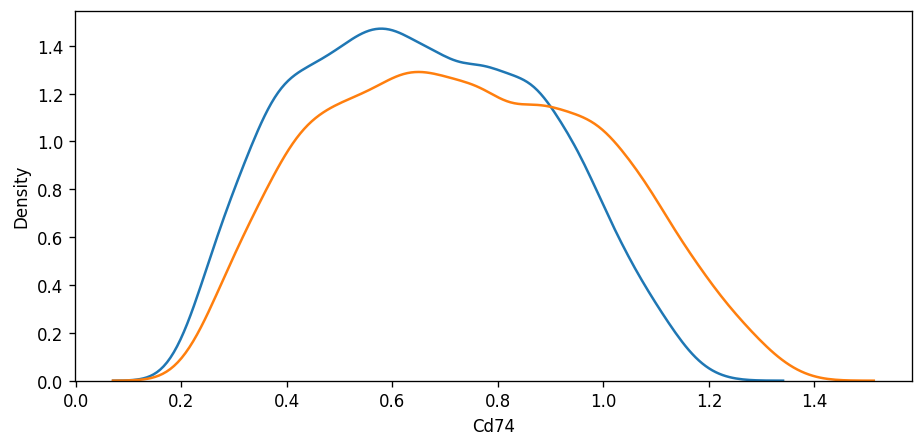

In [197]:
sns.kdeplot(co_matrix['Cd74'][so.adata.obs.rctd_cluster == 0])
sns.kdeplot(so.adata.to_df(layer='imputed_count')['Cd74'][so.adata.obs.rctd_cluster == 0])

In [78]:
adata_train.shape, co_matrix.shape

((11567, 5013), (11567, 5013))

In [79]:
adata_train.layers['imputed_count_x'] = MinMaxScaler().fit_transform(adata_train.layers['imputed_count'])

In [80]:
adata_train.layers['perturbed_so'] = perturbed_matrix
adata_train.layers['perturbed_co'] = co_matrix
adata_train.layers['perturbed_so_delta'] = adata_train.to_df(layer='imputed_count_x') - perturbed_matrix
adata_train.layers['perturbed_co_delta'] = adata_train.to_df(layer='imputed_count') - co_matrix

In [81]:
pd.DataFrame(adata_train.layers['perturbed_so_delta'], columns=adata_train.var_names).mean().abs().sort_values(ascending=False)[:20]

Pax5         0.275163
Adamts9      0.150953
Stard8       0.086178
Tle6         0.082890
Ptprg        0.080938
Susd2        0.075893
Calml4       0.073088
Adcy4        0.066785
Igkv8-21     0.061369
Sema3a       0.059735
Cdc42ep1     0.058975
Htr7         0.057196
Fam171a1     0.055559
Cd180        0.053125
Tbc1d2       0.052540
Plscr2       0.051925
Camk2n1      0.051903
Mtrf1        0.049716
Bmp2         0.048633
Serpina1e    0.048614
dtype: float64

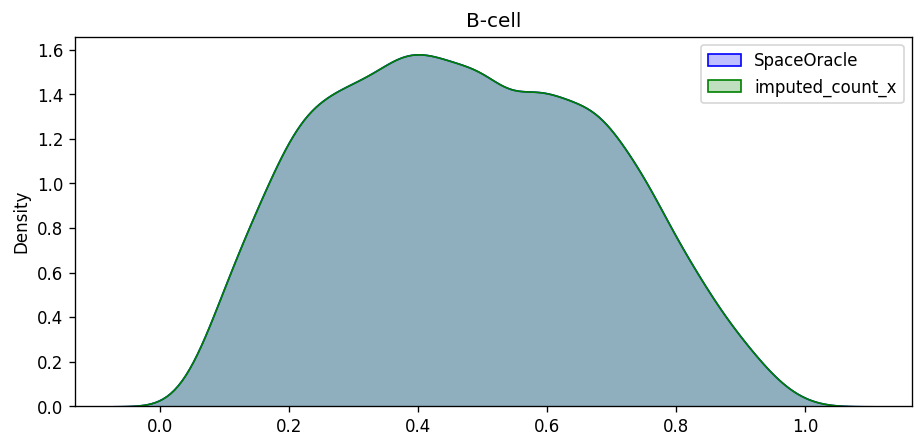

In [82]:
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['figure.dpi'] = 120

gene = 'Cd74'
cluster = 0
# sns.kdeplot(adata_train.to_df(
#     layer='perturbed_co')[so.adata.obs['rctd_cluster'] == cluster][gene].values, 
#     label='CellOracle', color='red', shade=True, linewidth=1)
sns.kdeplot(adata_train.to_df(
    layer='perturbed_so')[so.adata.obs['rctd_cluster'] == cluster][gene].values, 
    label='SpaceOracle', color='blue', shade=True, linewidth=1)
sns.kdeplot(adata_train.to_df(
    layer='imputed_count_x')[so.adata.obs['rctd_cluster'] == cluster][gene].values, 
    label='imputed_count_x', color='green', shade=True, linewidth=1)

plt.title('B-cell')
plt.legend()
plt.show()

In [111]:
delta = adata_train.to_df(layer='normalized_count') - adata_train.to_df(layer='perturbed')

In [112]:
delta.mean(0).sort_values(ascending=False)[:15]

Pax5       0.091604
Cd74       0.020498
H2-Ab1     0.012119
Rps20      0.004640
Rps12      0.004426
Mef2c      0.003682
Iglc3      0.002958
H2-DMb2    0.002511
Ms4a1      0.002447
Ifi30      0.002176
Fcer2a     0.001860
Pxk        0.001787
Iglc2      0.001603
Scd1       0.001360
Ralgps2    0.001234
dtype: float64

In [72]:
adata_train.to_df(layer='normalized_count')[['Cd74', 'Pax5']].mean()

Cd74    0.876883
Pax5    0.091604
dtype: float32

In [108]:
so.beta_dict['Pax5'].regulators.index('Mef2c')

9

In [110]:
[so.beta_dict['Pax5'].betas[so.adata.obs['rctd_cluster'] == i, :][:, 9].mean() for i in range(7)]

[-0.010842507,
 0.01111807,
 0.009431313,
 0.006326492,
 0.0104477275,
 -0.00088501396,
 0.0043515773]

In [106]:
so.grn.get_regulators_with_pvalues(so.adata, target_gene='Pax5').query('source == "Mef2c"')

,source,coef_mean
4,Mef2c,0.022826
19,Mef2c,0.022199
33,Mef2c,0.025515
48,Mef2c,0.007097
65,Mef2c,0.018683
77,Mef2c,0.009432
91,Mef2c,0.005980
